In [1]:
import dv_processing as dv
import torch
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader_refac import ModelLoader
from snn_delays.utils.train_utils_refact_minimal import get_device
from snn_delays.utils.hw_aware_utils import quantize_weights
from snn_delays.utils.hw_aware_utils import save_weights_delays, save_state
import numpy as np
import os
device = get_device() 

# For reproducibility
torch.manual_seed(10)

Running on: cuda:0


In [2]:
add_name = '_q8'

#ckpt_dir = 'exp_dvs_gesture_loihi_32'
#model = 'ibm_gestures200_hoNone_(24, 1)_8068181818181819_max_80epoch'
#model = 'ibm_gestures200_hoNone_(24, 1)_win_7575757575757575_max_100epoch'

#ckpt_dir = 'exp_dvs_gesture_loihi_32_40' # 120, 3e6
#model = 'ibm_gestures120_hoNone_(24, 2)_win_7613636363636364_max_80epoch' # 32x32
#model = 'ibm_gestures120_hoNone_(24, 2)_win_7121212121212122_max_95epoch' # 22x22

ckpt_dir = 'abcxo' # 250, 1e6
model = 'abcxo_f_9233333333333333' #32x32


In [3]:
dataset = 'davis'
total_time = 50
batch_size = 64
folder_name = 'ABCXO'

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 45,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

snn = ModelLoader(model, ckpt_dir, batch_size, device) 

[CenterCrop(sensor_size=(240, 180, 2), size=(180, 180)), Downsample(time_factor=1, spatial_factor=0.25, sensor_size=None, target_size=None), ToFrame(sensor_size=(45, 45, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]
Delta t: 5.0 ms
Delta t: 5.0 ms
Delta t: 5.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [ ]:
snn.input2spike_th = 0.5
_, __ = snn.test(test_loader)

Delta t: 5.0 ms
Delta t: 5.0 ms
Delta t: 5.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
600
Test Loss: 0.23076951839029788
Avg spk_count per neuron for all 50 time-steps 1157.1933333333334
Test Accuracy of the model on the test samples: 92.333



In [4]:
weight_params_names = [name for name, param in snn.named_parameters() if 'linear' in name]

In [5]:
weight_params_names

['layers.0.linear.weight', 'layers.1.linear.weight', 'layers.2.linear.weight']

In [29]:
def getattr_dotted(obj, attr_str):
    for attr in attr_str.split('.'):
        obj = getattr(obj, attr)
    return obj
getattr_dotted(snn, weight_params_names[0])

Parameter containing:
tensor([[-0.0121, -0.0124, -0.0119,  ...,  0.0057, -0.0149, -0.0136],
        [ 0.0076,  0.0028, -0.0129,  ...,  0.0052, -0.0036, -0.0023],
        [-0.0042,  0.0121,  0.0014,  ..., -0.0046, -0.0056,  0.0238],
        ...,
        [ 0.0078,  0.0188,  0.0017,  ...,  0.0119, -0.0092,  0.0247],
        [-0.0185,  0.0052, -0.0075,  ..., -0.0031, -0.0085, -0.0171],
        [ 0.0038,  0.0005,  0.0060,  ..., -0.0016,  0.0011, -0.0113]],
       device='cuda:0', requires_grad=True)

### Weight quantization

In [4]:
quantize_weights(snn, 8, last_layer=True, symmetry=True, print_info=True)
_, __ = snn.test(test_loader)

----layers.0.linear.weight----
n_unique before quantization: 258657, 116920 pos 141737 neg
max_value before quantization: 0.13369983434677124
n_unique after quantization: 188, 93 pos 94 neg
max_value after quantization: 0.1326553076505661, delta_w: 0.0010445299558341503
----layers.1.linear.weight----
n_unique before quantization: 4096, 2048 pos 2048 neg
max_value before quantization: 0.16806311905384064
n_unique after quantization: 207, 103 pos 103 neg
max_value after quantization: 0.16675013303756714, delta_w: 0.00131299311760813
----layers.2.linear.weight----
n_unique before quantization: 320, 182 pos 138 neg
max_value before quantization: 0.42832162976264954
n_unique after quantization: 77, 41 pos 35 neg
max_value after quantization: 0.42497536540031433, delta_w: 0.0033462627325206995
600
Test Loss: 0.32325255796313285
Avg spk_count per neuron for all 50 time-steps 1159.0
Test Accuracy of the model on the test samples: 89.500



<AxesSubplot:>

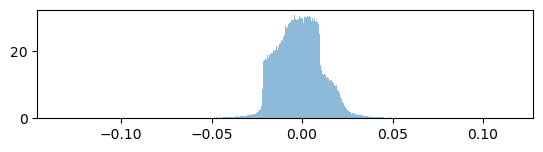

In [19]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
plt.subplot(311)
plot_param(snn.layers[0].linear, 'histogram_nonzero')
# plt.subplot(312)
# plot_param(snn.f1_o, 'histogram_nonzero')
# plt.subplot(313)
# plot_param(snn.f2_o, 'histogram_nonzero')

### Save weights, delays, spikes and mems

In [8]:
ckpt_dir_2 = 'weights_' + model + add_name
save_path = os.path.join(
    os.environ.get('SNN_CHECKPOINTS_PATH'), ckpt_dir, ckpt_dir_2)

save_weights_delays(snn, path=save_path)

no delays in this network. setting all delays to zero.
no delays in this network. setting all delays to zero.
no delays in this network. setting all delays to zero.
Weights and delays saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo\weights_abcxo_f_9233333333333333_q8
